# Inspect the bump at ~20Msun

there is a hardnekkige bump at 20Msun that appears very clearly in the stable mass transfer channel, but also in other systems. 

* Why is it there? 

First let's plot the mass distribution so you know what I'm talking about:

In [2]:
"""
# Plotting the stable BH mass distribution for several SFRD Z-distribution variations
"""
import matplotlib
from matplotlib import rc
import matplotlib.cm as cm
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py as h5 
import os
import time
from astropy.table import Table
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap


data_dir = '../data/'
simulation_data = '/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/'
sim_name = 'faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/'

######################################
## PLOT setttings
plt.rc('font', family='serif')
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30, 18,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize



In [3]:
sim_dir = simulation_data + sim_name

rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'


with h5.File(sim_dir + 'output/COMPAS_Output_wWeights.h5','r') as File:
        redshifts                 = File[rate_key]['redshifts'][()]
        DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        #(contains filter for RLOF>CE and optimistic CE)
        intrinsic_rate_density    = File[rate_key]['merger_rate'][()]
        
        print(File.keys())

<KeysViewHDF5 ['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned', 'Run_Details']>


## Some helper functions

In [4]:
#########################################
# Read LIgo data
#########################################
def read_ligo():
    color_plpeak = 'grey'
    ## grab Powerlaw + Peak data from O3
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    with h5.File(data_dir+'o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5', "r") as f:
        mass_ppd = f["ppd"]
        mass_lines = f["lines"]
        mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
        mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
        mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
    ##############################
    return mass_1, mass_1_lower, mass_1_upper, mass_1_ppd


#########################################
# Read COMPAS DCO data
#########################################
def read_data(loc = '', verbose=False):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            loc                  --> [string] Location of data
            rate_key             --> [string] group key name of COMPAS HDF5 data that contains your merger rate
            read_SFRD            --> [bool] If you want to also read in sfr data
            verbose              --> [bool] If you want to print statements while reading in 

        Returns:
            DCO                        --> [astropy table] contains all your double compact object
            DCO_mask                   --> [array of bool] reduces your DCO table to your systems of interest (determined in CI)
            rate_mask                  --> [array of bool] reduces intrinsic_rate_density to systems (flavour) of interest
            redshifts                  --> [array of floats] list of redshifts where you calculated the merger rate
            Average_SF_mass_needed     --> [float]    Msun SF needed to produce the binaries in this simulation
            intrinsic_rate_density     --> [2D array] merger rate in N/Gpc^3/yr
            intrinsic_rate_density_z0  --> [2D array] merger rate in N/Gpc^3/yr at finest/lowest redshift bin calculated

    """
    print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    if verbose: print(File.keys(), File[rate_key].keys())
    
    # Older simulations use this naming
    dcokey,  syskey, CEcount, dcomask = 'DoubleCompactObjects', 'SystemParameters', 'CE_Event_Count', 'DCOmask' 
    if dcokey in File.keys():
        if verbose: print('using file with key', dcokey)
    # Newer simulations use this
    else:
        if verbose: print('using file with key', dcokey)
        dcokey,  syskey, CEcount, dcomask = 'BSE_Double_Compact_Objects', 'BSE_System_Parameters', 'CE_Event_Counter', 'DCOmask'
 
    print(File[dcokey].keys())
    
    DCO = Table()
    for dco_param in ['SEED', 'Mass(1)', 'Mass(2)', 'Stellar_Type(1)', 'Stellar_Type(2)',
                      'MT_Donor_Hist(1)','MT_Donor_Hist(2)','dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)',
                      'Metallicity@ZAMS(1)', 'SemiMajorAxis@DCO', 'Eccentricity@DCO', 'Optimistic_CE', 'Immediate_RLOF>CE', CEcount]:
                      
        DCO[dco_param] = File[dcokey][dco_param][()]
        
    DCO['M_moreMassive']         = np.maximum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['M_lessMassive']         = np.minimum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['Mchirp']                = np.divide(np.power(np.multiply(DCO['M_moreMassive'], DCO['M_lessMassive']), 3./5.), np.power(np.add(DCO['M_moreMassive'], DCO['M_lessMassive']), 1./5.))

    SYS_DCO_seeds_bool           = np.in1d(File[syskey]['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
    # This needs to be done in two steps, otherwise the Snakemake workflow gets stuck for unknown reasons
    for sys_param in ['Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)']:
        SYSvalues = File[syskey][sys_param][()]
        DCO[sys_param]  =  SYSvalues[SYS_DCO_seeds_bool] 

    File.close()
    
    print('Done with reading DCO data for this file :)')
    return DCO

    
    # DCO['SEED']                  = File[dcokey]['SEED'][()] 
    # DCO[CEcount]                 = File[dcokey][CEcount][()] 
    # DCO['Mass(1)']               = File[dcokey]['Mass(1)'][()]
    # DCO['Mass(2)']               = File[dcokey]['Mass(2)'][()]
    # DCO['Stellar_Type(1)']       = File[dcokey]['Stellar_Type(1)'][()]
    # DCO['Stellar_Type(2)']       = File[dcokey]['Stellar_Type(2)'][()]
    # DCO['Optimistic_CE']         = File[dcokey]['Optimistic_CE'][()]
    # DCO['Immediate_RLOF>CE']     = File[dcokey]['Immediate_RLOF>CE'][()]
    # DCO['Metallicity@ZAMS(1)']   = File[dcokey]['Metallicity@ZAMS(1)'][()]

## The actual plot function

In [5]:
#########################################
# Plot mass function
#########################################
def plot_mass_distribution(ax, sim_dir='', rate_key='', sim_name='', x_key='M_moreMassive', 
                           bins=None, z_bin_edges=[0,0.25], 
                           plot_LIGO=False, show_hist=False, show_KDE=True,   
                           only_stable=True, only_CE=True, 
                           bootstrap=False, bootstraps=10, 
                           x_lim=(0.,50),  y_lim = (1e-3,30), Color='#e388b0', linestyles=['--','-', ':'], titletext='',
                           SimLab='', xlabel=r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', ylabel=r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                           leg_args=None, leg1_args=None,
                           save_plot=False, save_name='Fiducial.png', multipanel=False, subplot=None):
    """
    Read DCO, SYS and merger rate data, necessary to make the plots in this 

    Args:
        sim_dir              --> [string] Location of data

    Returns:
     plot

    """
    if rate_key is None:
        rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'
    if bins is None:
        bins = np.arange(0.,55,2.5)
    if leg_args is None:
        leg_args = {'loc':'lower left',  'bbox_to_anchor':[0.1, 0.], 'fontsize':20, 'title':''}
    if leg1_args is None:
        leg1_args = {'loc':'upper left', 'fontsize':18}
        
    mass_binw = np.diff(bins)[0]
    plot_lines = []
    leg_labels = []
    
    #############################
    # Reading data ##
    DCO = read_data(loc = sim_dir + '/' + sim_name + 'output/COMPAS_Output_wWeights.h5') # DCO data
    # print(DCO.info())
    
    # Rate data
    with h5.File(sim_dir + '/' + sim_name + '/output/COMPAS_Output_wWeights.h5','r') as File:
        # print(File.keys())
        if rate_key in File.keys():
            final_rate_key = rate_key
        else:
            final_rate_key = next((key for key in File.keys() if key.startswith('Rates_')), None)
        print('Using rate key: ', final_rate_key)
        redshifts                 = File[final_rate_key]['redshifts'][()]
        DCO_mask                  = File[final_rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        #(contains filter for RLOF>CE and optimistic CE)
        intrinsic_rate_density    = File[final_rate_key]['merger_rate'][()]

    #############################
    # Masking data ##
    print('Masking data')
    mask_start_t = time.time()
    CEcount = 'CE_Event_Count' if 'CE_Event_Count' in DCO.columns else 'CE_Event_Counter' # Old simulations use CE_Event_Count, newer ones CE_Event_Counter
    
    #first bring it to the same shape as the rate table
    merging_BBH = DCO[DCO_mask]
    # Are you interested in only stable or only CE channels?
    channel_bool = np.full(len(merging_BBH), True) if np.logical_and(only_stable, only_CE) else \
                merging_BBH[CEcount] == 0 if only_stable else \
                merging_BBH[CEcount] > 0 if only_CE else \
                ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
    #Adjust the labels correspondingly
    channel_string = 'All' if np.logical_and(only_stable, only_CE) else \
                'stable' if only_stable else \
                'CE' if only_CE else \
                ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
                
    # we exclude CHE systems
    not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16 
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
    
    # Apply all masks
    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    mask_end_t = time.time()
    print('done masking data: ', mask_end_t - mask_start_t, 'seconds')

    # Use the average rate density per z-bin
    i_redshift = np.where(redshifts == 0.2)[0][0]
    Weights = Red_intr_rate_dens[:, i_redshift]
    x_vals = merging_BBH[x_key]

    print(f'len(merging_BBH)={len(merging_BBH)} Rate = {np.sum(Weights)} Gpc-3 yr-1')

    # Get the Hist    
    print('Calculating histogram')
    hist, bin_edge = np.histogram(x_vals, weights=Weights, bins=bins)
    y_vals = hist / np.diff(bin_edge)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    # And the KDE
    print('Calculating KDE')
    kernel = stats.gaussian_kde(x_vals, bw_method='scott', weights=Weights)

    ################################################
    # Start drawing plot
    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 10))
    
    if show_hist:
        print('Plotting histogram')
        # plot_lines.append(ax.step(center_bins, y_vals, where='mid',lw=2.5, color='k', marker='o', markersize=15))

    if show_KDE:
        print('Plotting KDE')
        x_KDE = np.arange(0.1, 50., 0.1)
        KDEy_vals = kernel(x_KDE) * sum(hist)
        plot_lines.append(ax.plot(x_KDE, KDEy_vals, color=Color, lw=5, ls='-'))
        leg_labels.append(channel_string + SimLab)

    ################################################
    # GWTC-3 Powerlaw + Peak Mass distribution 
    if plot_LIGO:
        mass_1, mass_1_lower, mass_1_upper, mass_1_ppd  = read_ligo()
        # plot the max posterior and the 95th percentile
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="$\mathrm{GWTC-3}$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)
        legend1 = plt.legend(**leg1_args)
    
        
    #########################################
    # plot values
    print('start drawing axes stuff')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    # Channel
    plt.text(0.75, 0.66, '$\mathrm{%s \ channel}$'%(channel_string), ha = 'center', transform=ax.transAxes, size = 29)

    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.set_yscale('log')
    
    # fig.savefig(paths.data / 'miscFigures/Fid.pdf',  bbox_inches='tight', dpi=300)

    if ax is None:
        # add legend for simulations
        leg = ax.legend(**leg_args)
        leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
        leg._legend_box.align = "right"

        # Legend for GWTC-3
        if plot_LIGO:
            plt.gca().add_artist(legend1)
        
        plt.show()
    else:
        return plot_lines[0], leg_labels


# plot_mass_distribution(ax = None, sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
#                        sim_name='faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/', 
#                        rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
#                        only_stable=True, only_CE=False, show_hist=True, show_KDE=True,   )

Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized//faccFIXEDbeta0.0zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5


/tmp/ipykernel_1670354/1714936427.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [cm.get_cmap('viridis')(i) for i in np.linspace(0, 1, len(sim_names))]


<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight']>
Done with reading DCO data for this file :)
Using rate key:  Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned
Masking data
done masking data:  0.6267094612121582 seconds
len(merging_BBH)=29947 Rate = 10.10498234407213 Gpc-3 yr-1
Calculating histogram
Calculating KDE
Plotting histogram
Plotting KDE
start drawing axes stuff
Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized//faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity

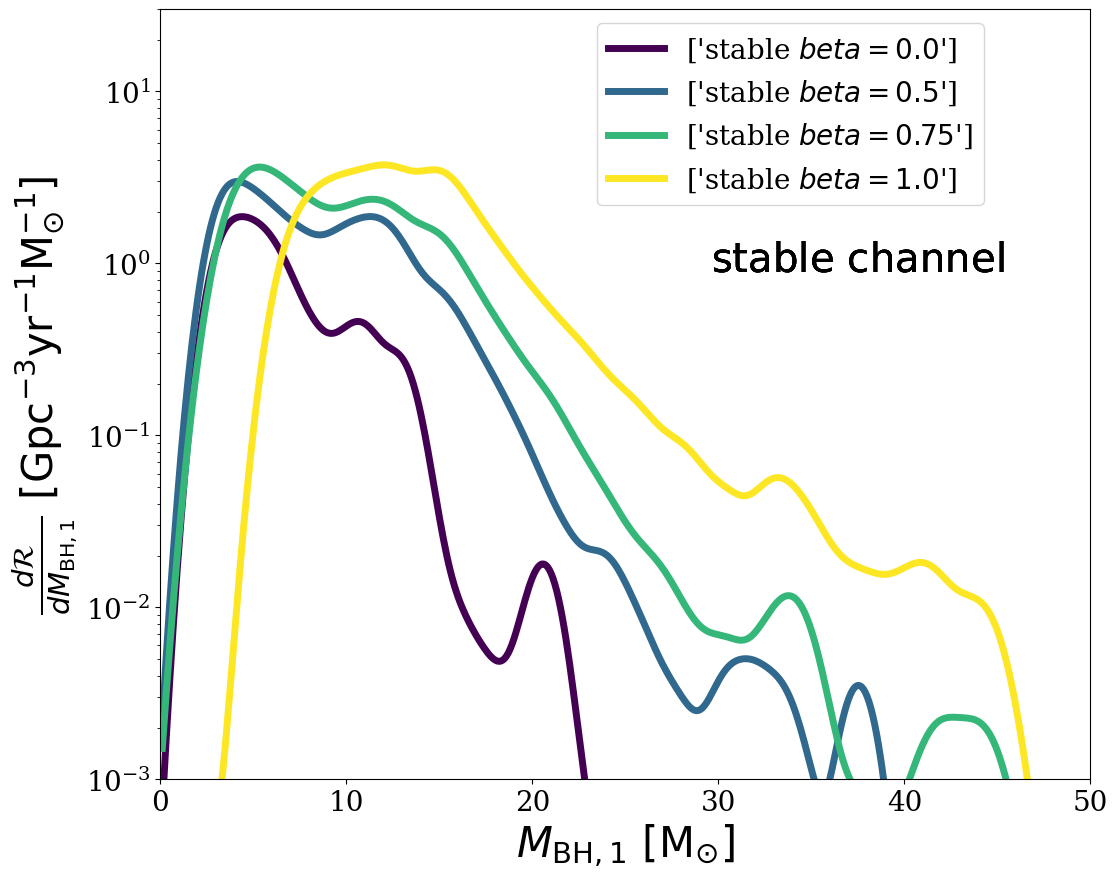

In [6]:

# Create a figure and axes
fig, ax = plt.subplots(figsize = (12, 10))

# List of simulation names
sim_names = ['faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/' % beta for beta in [0.0, 0.5, 0.75, 1.0]]

labels = [r' $beta = %s$' % beta for beta in [0.0, 0.5, 0.75, 1.0]]
colors = [cm.get_cmap('viridis')(i) for i in np.linspace(0, 1, len(sim_names))]

all_plot_lines, all_leg_labels = [], []
# Loop over simulation names
for i, sim_name in enumerate(sim_names):
    plot_lines, leg_labels = plot_mass_distribution(ax=ax, sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                        sim_name=sim_name, x_key='M_lessMassive', Color= colors[i],SimLab = labels[i],
                        rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                        only_stable=True, only_CE=False, show_hist=True, show_KDE=True)
    
    all_plot_lines.append([plot_lines[i] for i in range(len(plot_lines)) ]) 
    all_leg_labels.append(leg_labels)
    
# Show the figure
# add legend for simulations
leg_args = {'loc':'upper right',  'bbox_to_anchor':[0.9, 1.], 'fontsize':20, 'title':''}
leg = plt.legend([l[0] for l in all_plot_lines], [l for l in all_leg_labels ],  **leg_args)
leg._legend_box.align = "right"

plt.show()





# Let's subdivide our histogram by certain properties

In [7]:
def plot_distribution(ax, x_vals, weights, bins, x_lim=(0.,50),  y_lim = (1e-3,30), color='#e388b0', 
                      linestyle='-', 
                      plot_ligo=False, show_hist=False, show_kde=True, channel_string = '',
                      sim_label='', xlabel=r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', ylabel=r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                      legend_args=None, legend1_args=None):
    """
    This function plots a KDE of the distribution.
    """
    # Calculate histogram
    hist, bin_edge = np.histogram(x_vals, weights=weights, bins=bins)
    y_vals = hist / np.diff(bin_edge)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    # Calculate KDE
    kernel = stats.gaussian_kde(x_vals, bw_method='scott', weights=weights)

    # Plot histogram
    if show_hist:
        ax.step(center_bins, y_vals, where='mid',lw=1.5, color=color, marker='o', markersize=10)

    # Plot KDE
    if show_kde:
        x_kde = np.arange(0.1, 50., 0.1)
        kde_y_vals = kernel(x_kde) * sum(hist)
        plot_lines = ax.plot(x_kde, kde_y_vals, color=color, lw=5, ls=linestyle)
        
    # Plot LIGO data
    if plot_ligo:
        mass_1, mass_1_lower, mass_1_upper, mass_1_ppd  = read_ligo()
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="$\mathrm{GWTC-3}$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)
        legend1 = ax.legend(**legend1_args)
    
    # Set plot limits and labels
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.set_yscale('log')

    # Set legend
    if legend_args is not None:
        ax.legend(legend_labels, **legend_args)
        
    if ax is None:
        # add legend for simulations
        legend_labels = [channel_string + sim_label]
        leg = ax.legend(**leg_args)
        leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
        leg._legend_box.align = "right"

        # Legend for GWTC-3
        if plot_LIGO:
            plt.gca().add_artist(legend1)
        
        plt.show()
    else:
        return plot_lines[0] 
    

In [8]:

#############################
def read_and_mask(sim_dir='', rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                  sim_name='', x_key='M_moreMassive', only_stable=True, only_CE=True):
    """
    This function reads and masks the data.
    """
    # Reading data ##
    DCO = read_data(loc = os.path.join(sim_dir, sim_name, 'output', 'COMPAS_Output_wWeights.h5')) # DCO data
    
    # Rate data
    with h5.File(os.path.join(sim_dir, sim_name, 'output', 'COMPAS_Output_wWeights.h5'),'r') as File:
        if rate_key in File.keys():
            final_rate_key = rate_key
        else:
            final_rate_key = next((key for key in File.keys() if key.startswith('Rates_')), None)
        redshifts                 = File[final_rate_key]['redshifts'][()]
        DCO_mask                  = File[final_rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        intrinsic_rate_density    = File[final_rate_key]['merger_rate'][()]

    #############################
    # Masking data ##
    mask_start_t = time.time()
    CEcount = 'CE_Event_Count' if 'CE_Event_Count' in DCO.columns else 'CE_Event_Counter' # Old simulations use CE_Event_Count, newer ones CE_Event_Counter
    
    #first bring it to the same shape as the rate table
    merging_BBH = DCO[DCO_mask]
    # Are you interested in only stable or only CE channels?
    if np.logical_and(only_stable, only_CE):
        channel_bool = np.full(len(merging_BBH), True)
        channel_string = 'All'
    elif only_stable:
        channel_bool = merging_BBH[CEcount] == 0
        channel_string = 'stable'
    elif only_CE:
        channel_bool = merging_BBH[CEcount] > 0
        channel_string = 'CE'
    else:
        raise ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
                
    # we exclude CHE systems
    not_CHE  = merging_BBH['Stellar_Type@ZAMS(1)'] != 16 
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
    
    # Apply all masks
    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    mask_end_t = time.time()
    print('done masking data: ', mask_end_t - mask_start_t, 'seconds')
        
    return merging_BBH, Red_intr_rate_dens, channel_string


Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/faccFIXEDbeta0.0zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight']>


Done with reading DCO data for this file :)
done masking data:  0.514847993850708 seconds
b 0
len(x_vals)=22016 Rate = 7.652368544014129 Gpc-3 yr-1
b 1
len(x_vals)=7931 Rate = 2.452613800058 Gpc-3 yr-1
Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/faccFIXEDbeta0.25zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight']>
Done with reading DCO data for this file :)
done masking data:  0.5418417453765869 seconds
b 0
len(x_vals)=38858 Rate = 11.321458934140958 Gpc-3 yr-1
b 1
len(x_vals)=59359 Rate = 6.036461554516342 Gpc-3 yr-1
Reading  /mnt/home/lva

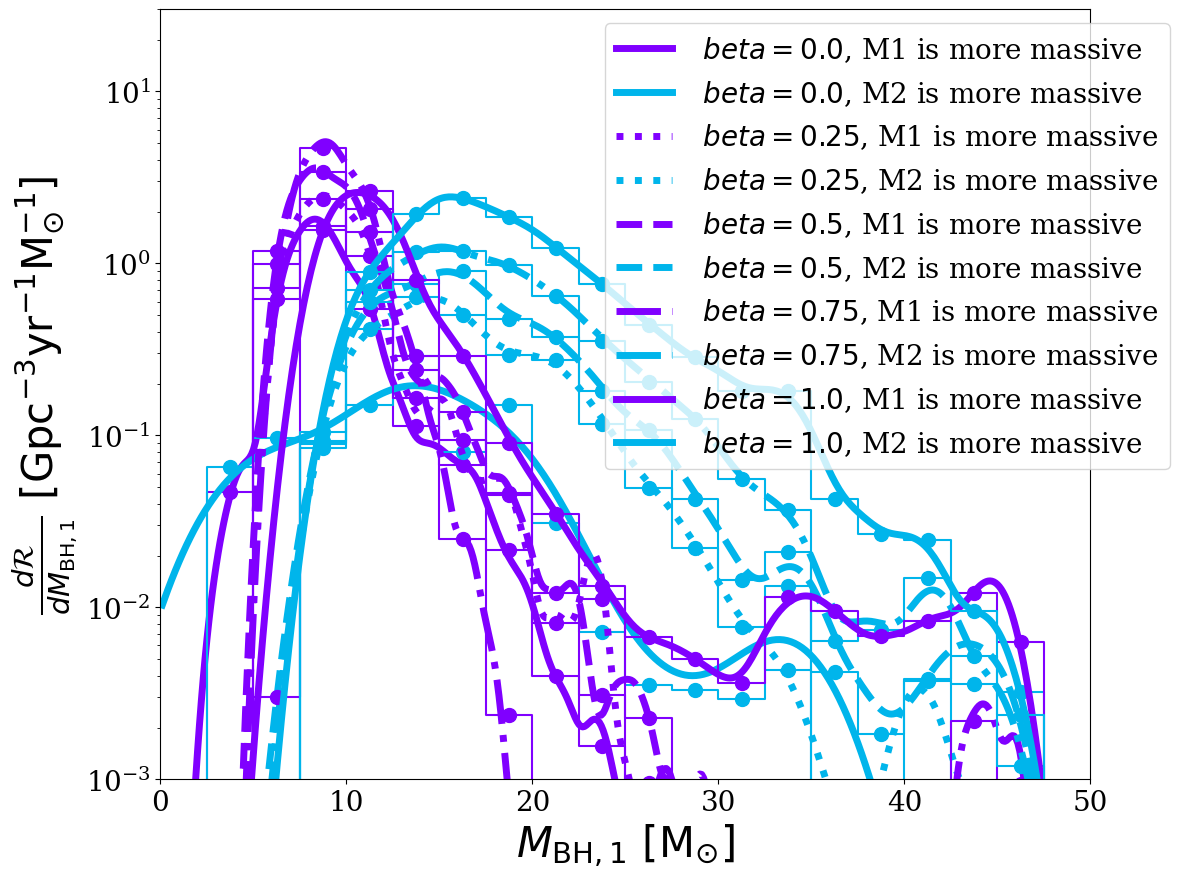

In [9]:

############################################################
# Create a figure and axes
fig, ax = plt.subplots(figsize = (12, 10))

BETA = 0.5
# List of simulation names
sim_names = ['faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/' % beta for beta in [0.0, 0.25, 0.5, 0.75, 1.0]]
# sim_names = ['faccTHERMALzetaHG6.0RemMassFRYER2012SNDELAYED']

labels = [r' $beta = %s$' % beta for beta in [0.0, 0.25, 0.5, 0.75, 1.0]] #['thermal beta']#
colors = [matplotlib.colormaps['rainbow'](i) for i in np.linspace(0, 1, 5)]
linestyles = ['-', ':', '--', '-.', '-'] 
all_plot_lines, all_leg_labels = [], []

# Loop over simulation names
for i, sim_name in enumerate(sim_names):
    # First read and mask the data
    merging_BBH, Red_intr_rate_dens, channel_string = read_and_mask(sim_name=sim_name, 
                                            sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                                            rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                                            only_stable=True, only_CE=False)

    # Now lets add an extra mask
    # merging_BBH['qZAMS'] = merging_BBH['Mass@ZAMS(2)']/merging_BBH['Mass@ZAMS(1)']
    # bool_list = [merging_BBH['qZAMS'] <= 0.25, np.logical_and(0.25 < merging_BBH['qZAMS'], merging_BBH['qZAMS'] <= 0.45),\
    #     np.logical_and(0.45 < merging_BBH['qZAMS'], merging_BBH['qZAMS'] <= 0.65), np.logical_and(0.65 < merging_BBH['qZAMS'],  merging_BBH['qZAMS'] <= 0.85),  merging_BBH['qZAMS'] > 0.85 ]
    # bool_labels = [' qZAMS <= 0.25', ' 0.25 < qZAMS <= 0.45', ' 0.45 < qZAMS <= 0.65', ' 0.65 < qZAMS <= 0.85',  ' qZAMS > 0.85']
    
    bool_list = [merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'], merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'] ]
    bool_labels = ['M1 is more massive', 'M2 is more massive']
    
    # Use the average rate density per z-bin
    i_redshift = np.where(redshifts == 0.2)[0][0]
    
    for b, bool in enumerate(bool_list):
        print('b', b)
        # Check if there are any systems left
        if np.sum(bool) == 0:
            print(bool_labels[b], 'has no systems left')
            continue
        
        Weights    = Red_intr_rate_dens[bool, i_redshift]
        x_vals     = merging_BBH['M_moreMassive'][bool]

        print(f'len(x_vals)={len(x_vals)} Rate = {np.sum(Weights)} Gpc-3 yr-1')
    
        plot_lines =  plot_distribution(ax, x_vals, Weights, bins=np.arange(0.,55,2.5),
                        plot_ligo=False, show_hist=True, show_kde=True, 
                        x_lim=(0.,50),  y_lim = (1e-3,30), 
                        color= colors[b], linestyle = linestyles[i], 
                        xlabel=r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', 
                        ylabel=r'$\frac{d\mathcal{R}}{dM_{\mathrm{BH, 1} }} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                        legend_args=None, legend1_args = None)
        
        # leg_labels = [channel_string + labels[i]]        
        # all_plot_lines.append([plot_lines[i] for i in range(len(plot_lines)) ]) 
        all_plot_lines.append(plot_lines) 
        all_leg_labels.append(labels[i] + ', '+ bool_labels[b])

# Show the figure
# add legend for simulations
leg_args = {'loc':'upper right',  'bbox_to_anchor':[1.1, 1.], 'fontsize':20, 'title':''}
leg = plt.legend([l for l in all_plot_lines], [l for l in all_leg_labels ],  **leg_args)
leg._legend_box.align = "right"

plt.show()   
    
 

## Let's select the subset of systems that form the bump at 35Msun

In [10]:
merging_BBH, Red_intr_rate_dens, channel_string = read_and_mask(sim_name='faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/', 
                                        sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                                        rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                                         only_stable=True, only_CE=False)

merging_BBH.info()

M2_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'] ]
i_redshift = np.where(redshifts == 0.2)[0][0]

M2_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'], i_redshift]

print(np.unique(M2_moremass_BBH['MT_Donor_Hist(1)'] )  )
print(np.unique(M2_moremass_BBH['MT_Donor_Hist(2)'] )  )

# Define color map for MT_Donor_Hist(1)
color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}
# print([val for val in M2_moremass_BBH['MT_Donor_Hist(2)']])


# Create a new column 'color' in the table
M2_moremass_BBH['MT1color'] = [color_map[val] if val in color_map else -1 for val in M2_moremass_BBH['MT_Donor_Hist(1)']]
M2_moremass_BBH['MT2color'] = [color_map[val] if val in color_map else -1 for val in M2_moremass_BBH['MT_Donor_Hist(2)']]


Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight']>


Done with reading DCO data for this file :)
done masking data:  0.6255970001220703 seconds
<Table length=221684>
        name          dtype 
-------------------- -------
                SEED  uint64
             Mass(1) float64
             Mass(2) float64
     Stellar_Type(1)   int32
     Stellar_Type(2)   int32
    MT_Donor_Hist(1) bytes17
    MT_Donor_Hist(2) bytes17
             dmMT(1) float64
             dmMT(2) float64
          dmWinds(1) float64
          dmWinds(2) float64
 Metallicity@ZAMS(1) float64
   SemiMajorAxis@DCO float64
    Eccentricity@DCO float64
       Optimistic_CE   uint8
   Immediate_RLOF>CE   uint8
    CE_Event_Counter  uint32
       M_moreMassive float64
       M_lessMassive float64
              Mchirp float64
Stellar_Type@ZAMS(1)   int32
Stellar_Type@ZAMS(2)   int32
        Mass@ZAMS(1) float64
        Mass@ZAMS(2) float64
MT_Donor_Hist(1)
----------------
1-2             
2               
4               
NA              
MT_Donor_Hist(2)
--------------

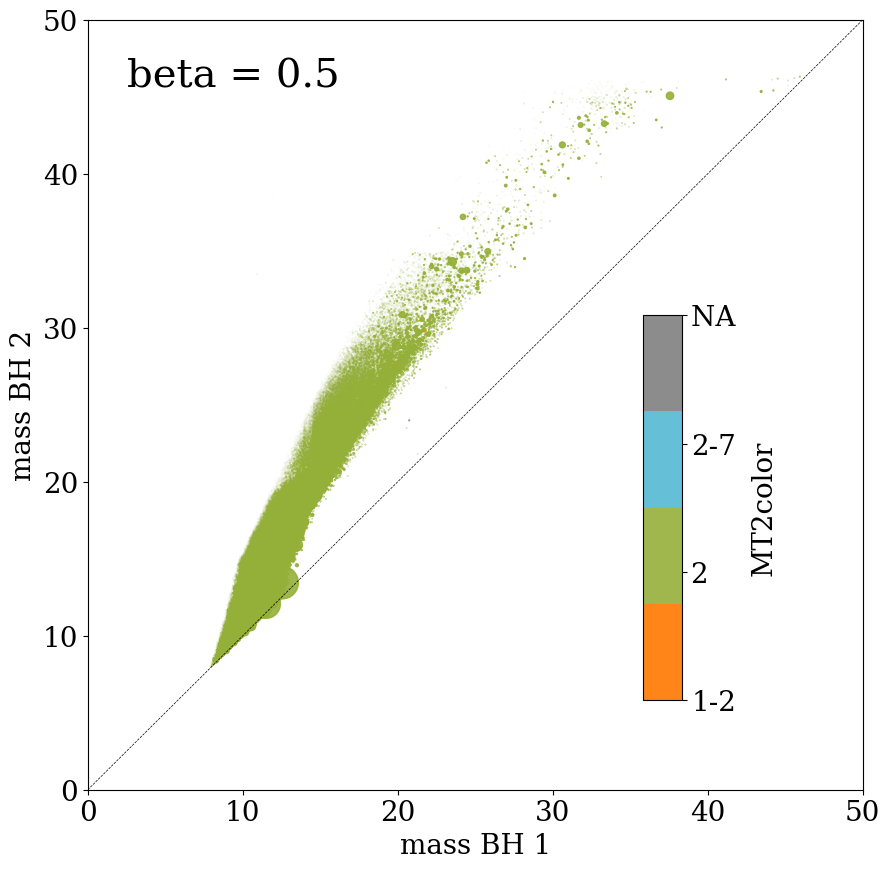

In [11]:

colors = ['#ff7800', '#95b038','#54b9d3','grey'] # Define the colors for 0, 1, 2, 3
discrete_cmap = ListedColormap(colors) # Create the colormap


# dmWinds and dmMT are fake news

fig, ax = plt.subplots(figsize = (10, 10))

plt.plot(np.linspace(0,50,100), np.linspace(0,50,100), '--', color='k', lw = 0.5)

kleur = 'MT2color' # np.log10(M2_moremass_BBH['Metallicity@ZAMS(1)'])
im = plt.scatter(M2_moremass_BBH['Mass(1)'], M2_moremass_BBH['Mass(2)'], 
            s = 4000* M2_moremass_Weights, c = M2_moremass_BBH[kleur], 
            alpha = 0.9, cmap = discrete_cmap, vmin = 0, vmax = 3 )

# Create an inset axes for the colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 5% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left', bbox_to_anchor=(0.7, 0.1, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = kleur )
# Set the colorbar tick locations and labels
cbar.set_ticks(list(range(len(color_map) )))
cmap_ticks = [key.replace('             ', '') for key in color_map.keys()]
cbar.set_ticklabels(cmap_ticks)

ax.text(0.05, 0.95, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=29)

ax.set_xlabel('mass BH 1')
ax.set_ylabel('mass BH 2')
ax.set_ylim(0,50)
ax.set_xlim(0,50)
plt.show()

# Let's go back to my analytical solutions for min MBH1, and MBH2

In [12]:
BETA = 0.75 # 'THERMAL' #
sim_name = 'faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA) #'facc%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA)  #

merging_BBH, Red_intr_rate_dens, channel_string = read_and_mask(sim_name= sim_name,
                                        sim_dir='/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/', 
                                        rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                                         only_stable=True, only_CE=False)

merging_BBH.info()

M1_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'] ]
M2_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'] ]

i_redshift = np.where(redshifts == 0.2)[0][0]
M1_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'], i_redshift]
M2_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'], i_redshift]

print(np.unique(M2_moremass_BBH['MT_Donor_Hist(1)'] )  )
print(np.unique(M2_moremass_BBH['MT_Donor_Hist(2)'] )  )

# Define color map for MT_Donor_Hist(1)
color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}
# print([val for val in M2_moremass_BBH['MT_Donor_Hist(2)']])


# Create a new column 'color' in the table
M1_moremass_BBH['MT1color'] = [color_map[val] if val in color_map else -1 for val in M1_moremass_BBH['MT_Donor_Hist(1)']]
M1_moremass_BBH['MT2color'] = [color_map[val] if val in color_map else -1 for val in M1_moremass_BBH['MT_Donor_Hist(2)']]

M2_moremass_BBH['MT1color'] = [color_map[val] if val in color_map else -1 for val in M2_moremass_BBH['MT_Donor_Hist(1)']]
M2_moremass_BBH['MT2color'] = [color_map[val] if val in color_map else -1 for val in M2_moremass_BBH['MT_Donor_Hist(2)']]

Reading  /mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/faccFIXEDbeta0.75zetaHG6.0RemMassFRYER2012SNDELAYED/output/COMPAS_Output_wWeights.h5
<KeysViewHDF5 ['CE_Event_Counter', 'Coalescence_Time', 'Eccentricity@DCO', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)', 'mixture_weight']>


Done with reading DCO data for this file :)
done masking data:  0.9319300651550293 seconds
<Table length=581432>
        name          dtype 
-------------------- -------
                SEED  uint64
             Mass(1) float64
             Mass(2) float64
     Stellar_Type(1)   int32
     Stellar_Type(2)   int32
    MT_Donor_Hist(1) bytes17
    MT_Donor_Hist(2) bytes17
             dmMT(1) float64
             dmMT(2) float64
          dmWinds(1) float64
          dmWinds(2) float64
 Metallicity@ZAMS(1) float64
   SemiMajorAxis@DCO float64
    Eccentricity@DCO float64
       Optimistic_CE   uint8
   Immediate_RLOF>CE   uint8
    CE_Event_Counter  uint32
       M_moreMassive float64
       M_lessMassive float64
              Mchirp float64
Stellar_Type@ZAMS(1)   int32
Stellar_Type@ZAMS(2)   int32
        Mass@ZAMS(1) float64
        Mass@ZAMS(2) float64
MT_Donor_Hist(1)
----------------
1-2             
2               
4               
NA              
MT_Donor_Hist(2)
--------------

In [13]:
import MinimumMassFunctions as mfunc
import importlib
importlib.reload(mfunc)

##########################
# Define the variables
##########################
qzams       = np.arange(0.25,1.01, 0.01)
use_zeta    = False
zeta_list   = [6.0]#[3.5, 4.5, 5.5, 6.0, 6.5]

q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta_list)
qcrit2_list = q_crits[:,1]

use_dMsn  = True
A_sn      = -0.9  #-0.9
B_sn      = 13.9  #13.9
M_threshold = 14.8 #14.8

Fc1 = 0.34
beta = BETA

# Simnames
# simnames = ['faccFIXEDbeta0.5zetaHG%sRemMassFRYER2012SNDELAYED/'%(ZETA) for ZETA in zeta_list]

##########################
# Define values and add columns
Weights = Red_intr_rate_dens[:, i_redshift]
merging_BBH['qZAMS'] = merging_BBH['Mass@ZAMS(2)']/merging_BBH['Mass@ZAMS(1)']
# Define color map for MT_Donor_Hist
color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}
# Create a new column 'color' in the table
merging_BBH['MT1color'] = [color_map[val] if val in color_map else -1 for val in merging_BBH['MT_Donor_Hist(1)']]
merging_BBH['MT2color'] = [color_map[val] if val in color_map else -1 for val in merging_BBH['MT_Donor_Hist(2)']]

##########################
# Get minimum Mbh1,2 and ZAMS
##########################
MBH1_list, MBH2_list, MZAMS_list = [],[],[]
for qi, qcrit2 in enumerate(qcrit2_list):
    # Mbh1
    Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta_list[qi], qcrit1 = qzams, qcrit2 = qcrit2, 
                                                Fc1 = Fc1, M_threshold = M_threshold,Beta = beta, verbose = False,
                                                use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
    MBH1_list.append(Min_MBH1)
    # Mbh2
    minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
    MBH2_list.append(minM_BH2)
    # Mzams1
    Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = beta, fc1 = Fc1, asn = A_sn, bsn= B_sn)
    MZAMS_list.append(Minzams1)

print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)


Zeta_eff is not a float
using method A, fc = const, dMsn(M)
using predefined MBH1 and qcrits
qzams [0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38
 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52
 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66
 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8
 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94
 0.95 0.96 0.97 0.98 0.99 1.  ] Min_MBH1 [ 5.06130971  5.15443937  5.24848837  5.34347039  5.43939939  5.53628959
  5.63415551  5.73301198  5.8328741   5.9337573   6.03567732  6.13865022
  6.24269242  6.34782064  6.45405198  6.5614039   6.66989422  6.77954115
  6.89036328  7.0023796   7.11560953  7.23007289  7.34578995  7.46278142
  7.58106846  7.70067273  7.82161633  7.94392191  8.06761259  8.19271204
  8.31924447  8.44723463  8.57670786  8.7076901   8.84020787  8.97428835
  9.10995932  9.24724927  9.38618735  9.52680341  9.66912804  9.8131

/tmp/ipykernel_1670354/4118884287.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipykernel_1670354/4118884287.py:46: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T,


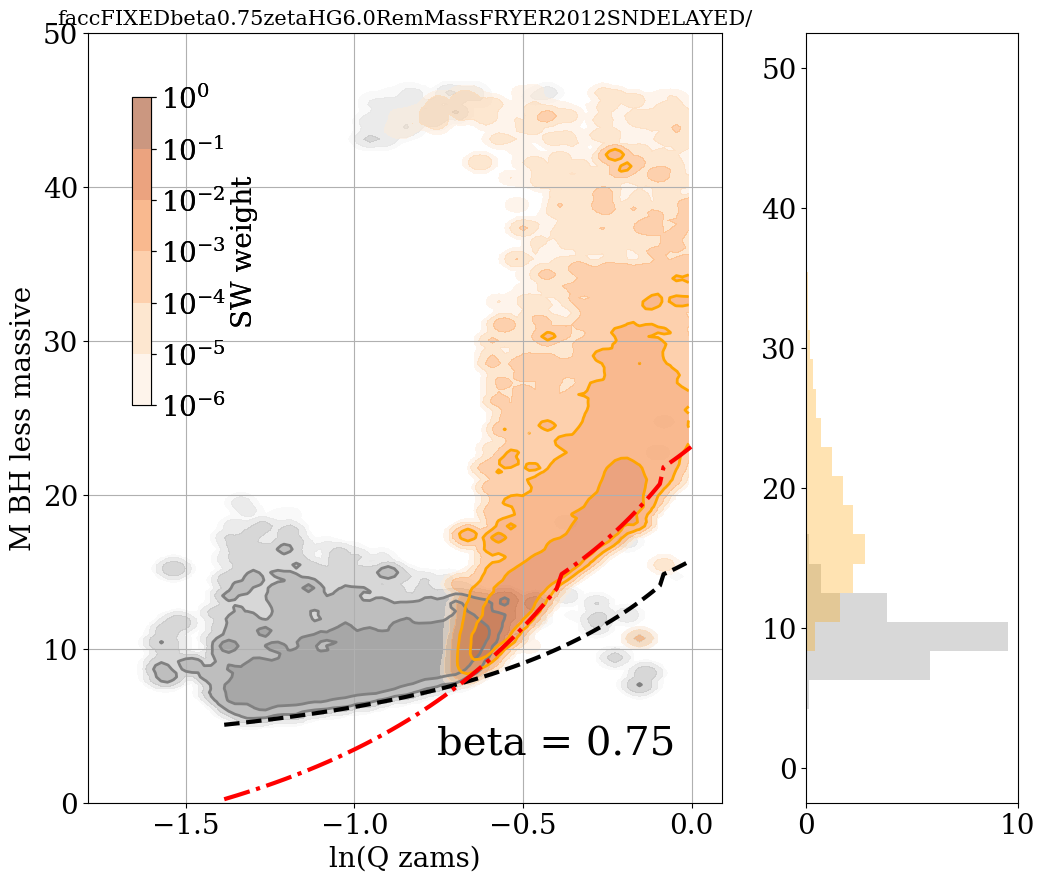

In [81]:
from matplotlib.colors import LogNorm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.gridspec as gridspec



to_plot_table = merging_BBH # M2_moremass_BBH 
to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']
to_plot_weight =  Weights #  M2_moremass_Weights #

Weights_list = [M1_moremass_Weights, M2_moremass_Weights]
colors = ['Grey', 'Orange']
##########################
# Scatter plot
##########################
fig = plt.figure(figsize=(12, 10))

# Create a gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

#######################
# Create the first axes for the contour plot
ax = plt.subplot(gs[0])

# Create the second axes for the y-value histogram
ax2 = plt.subplot(gs[1])

# Define the bins and levels
x_bins = np.linspace(-1.8,0,100) #np.linspace(0, 1.1, 100)
y_bins = np.linspace(0, 50, 200)
levels = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for i, to_plot_table in enumerate([M1_moremass_BBH, M2_moremass_BBH]):
    # to_plot_table = merging_BBH # M2_moremass_BBH 
    to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']
    to_plot_weight =  Weights_list[i] #Weights #  M2_moremass_Weights #
    
    # Create a 2D histogram
    hist, x_edges, y_edges = np.histogram2d(np.log(to_plot_table['qZAMS']), to_plot_table['M_moreMassive'],
                                            bins=[x_bins, y_bins], weights= to_plot_weight)

    # Apply a Gaussian filter to the histogram
    hist = gaussian_filter(hist, sigma=0.9)

    # Create the contour plot
    im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels, alpha = 0.5, cmap=colors[i]+'s', norm=LogNorm() )
    # Add contour lines
    contour_lines = ax.contour((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels[3:], colors=colors[i], linewidths=2)
    
    # Create an inset axes for the colorbar
    cax = inset_axes(ax,
                    width="3%",  # width = 5% of parent_bbox width
                    height="40%",  # height : 50%
                    loc='lower left', bbox_to_anchor=(0.05, 0.5, 1, 1), bbox_transform=ax.transAxes)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = 'SW weight')

    #######################
    # Create the histogram
    ax2.hist(to_plot_table['M_moreMassive'], bins=np.linspace(0,50,25), weights = to_plot_weight,
            orientation='horizontal', color=colors[i], alpha=0.3)
#######
ax.plot(np.log(qzams), Min_MBH1, color = 'k', lw = 3, ls = '--', label = 'min Mbha')
ax.plot(np.log(qzams), minM_BH2, color = 'red', lw = 3, ls = '-.', label = 'min Mbhb')
# print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)


#######
ax.text(0.55, 0.1, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=29)

ax.set_xlabel('ln(Q zams)')
ax.set_ylabel('M BH less massive')
ax.set_ylim(0,50)
# ax.set_xlim(0,1.1)

ax.grid(True)

ax.set_title(sim_name, fontsize =15)

plt.show()

# Convey constant weight in IMF

I'm trying to represent the y-axis relative to the IMF weights. 
Assuming that the IMF follows the powerlaw: 

\begin{equation}
PDF = m^{-\alpha} m^{-2.3}
\end{equation}

where I've used $\alpha = 2.3$
then the CDF

\begin{equation}
CDF = \int_{-inf}^{x} m^{-2.3} dm  = \frac{-1}{1.3} x^{-1.3}
\end{equation}


The probability for some value to be in a bin is $CDF(y_i + \Delta y) - CDF(y)$
I'm tring to solve when this will be constant. I.e., I'm looking for a function of $\Delta y$ such that 

\begin{equation}
 CDF(y_i + \Delta y) - CDF(y)  = const 
\end{equation}

writing this out we get

\begin{equation}
 \frac{-1}{\alpha - 1} \Biggl( y_i + \Delta y \Biggr) ^{-\alpha + 1} + \frac{1}{\alpha - 1} y_i^{\alpha + 1} = const 
\end{equation}

or again with $\alpha = 2.3$ 

\begin{equation}
 \frac{-1}{1.3} \Biggl( y_i + \Delta y \Biggr) ^{-1.3} + \frac{1}{1.3} y_i^{-1.3} = c 
\end{equation}

Solving this for $\Delta y$ we get:


\begin{equation}
\boxed{
 \Delta y = \Biggl( \frac{- c * (\alpha-1)}{k} + y_i^{(1-\alpha)} \Biggr)^{1/(1-\alpha)}  - y_i
}
\end{equation}



In [83]:
# Equation to determine the delta_y needed to get a constant CDF
def delta_y(y_i, a = 2.3, k = 1, c = 1e-3):
    """
    yi: y value to start from
    Assuming a powerlaw: k x**-a
    a: power law index 
    k: constant 
    c: constant CDF difference, 
    e.g., how 'probable' you want your bin step to be
    """
    return ( -c *(a-1)/k  +  y_i**(1-a) )**(1/(1-a))  - y_i
    
# Bottom value of your y array
y_start = 5

# Itteratively calculate the y values
Y_ticks = [y_start]
y = y_start
while y < 45: 
    dy = delta_y(y, a = 2.3, k = 1, c = 1e-2) 
    # print('y', y, 'dy', dy, 'y+dy', y+dy)
    y += dy
    Y_ticks.append(y)
    
print('Y_ticks', Y_ticks)

print('constant CDF? ', -1/1.3 * np.array([Y_ticks[i]**-1.3 - Y_ticks[i+1]**-1.3 for i in range(len(Y_ticks)-1)]) )



Y_ticks [5, 5.446997082048909, 5.998025989944612, 6.696742802949584, 7.616210168421532, 8.889441064080225, 10.789072905190379, 13.985074489057247, 20.747175845032913, 48.663185446392745]
constant CDF?  [-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01]


# Now let's scale our y axis

/tmp/ipykernel_1670354/867273146.py:2: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipykernel_1670354/867273146.py:50: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T,


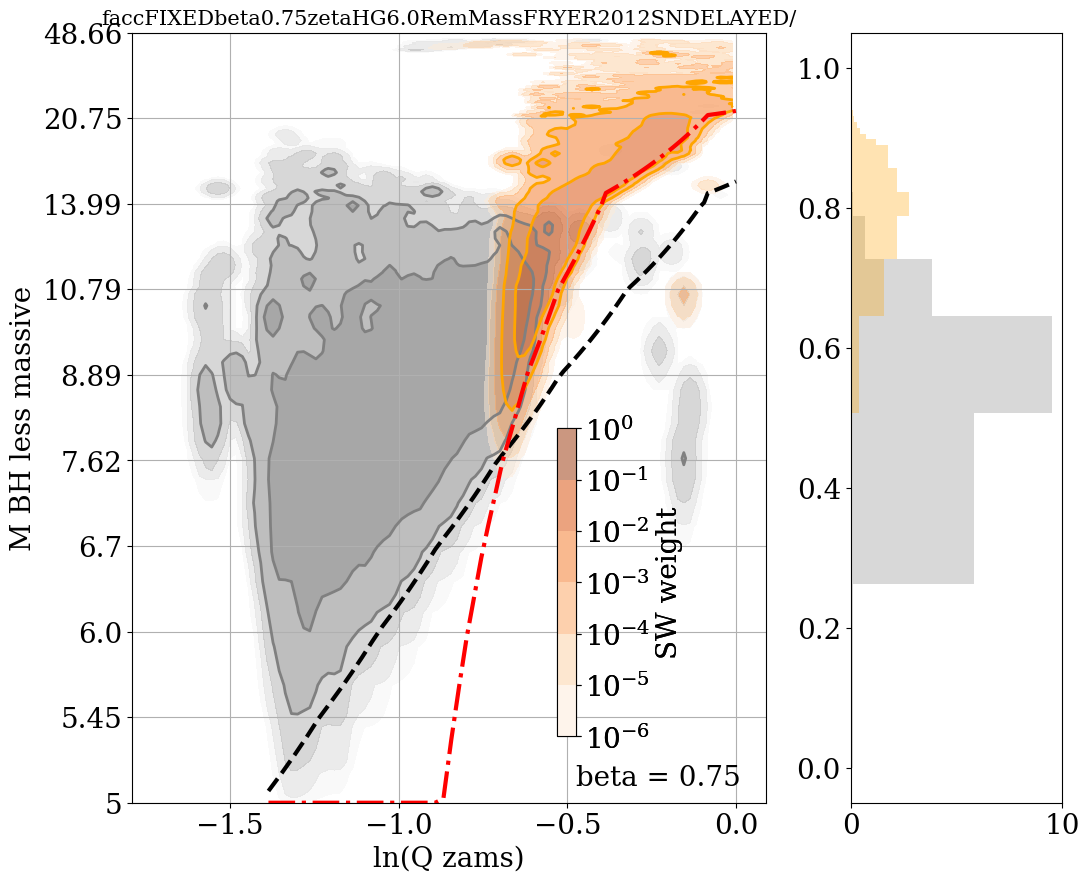

In [108]:
from matplotlib.colors import LogNorm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.gridspec as gridspec

to_plot_table = merging_BBH # M2_moremass_BBH 
to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']
to_plot_weight =  Weights #  M2_moremass_Weights #

Weights_list = [M1_moremass_Weights, M2_moremass_Weights]
colors = ['Grey', 'Orange']
##########################
# Scatter plot
##########################
fig = plt.figure(figsize=(12, 10))

# Create a gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

#######################
# Create the first axes for the contour plot
ax = plt.subplot(gs[0])

# First define new y values
new_Y_ticks = np.linspace(0, 1, len(Y_ticks))

# Create the second axes for the y-value histogram
ax2 = plt.subplot(gs[1])

# Define the bins and levels
x_bins = np.linspace(-1.8,0,100) #np.linspace(0, 1.1, 100)
y_bins = np.linspace(0, 50, 200)
# Adjust the levels to the new y values
new_y_bins = np.interp(y_bins, Y_ticks, new_Y_ticks)
levels = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for i, to_plot_table in enumerate([M1_moremass_BBH, M2_moremass_BBH]):
    # to_plot_table = merging_BBH # M2_moremass_BBH 
    to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']
    to_plot_weight =  Weights_list[i] #Weights #  M2_moremass_Weights #
    
    # Create a 2D histogram
    new_y_vals = np.interp(to_plot_table['M_moreMassive'], Y_ticks, new_Y_ticks) 
    hist, x_edges, y_edges = np.histogram2d(np.log(to_plot_table['qZAMS']), new_y_vals,
                                            bins=[x_bins, new_y_bins], weights= to_plot_weight)

    # Apply a Gaussian filter to the histogram
    hist = gaussian_filter(hist, sigma=0.9)

    # Create the contour plot
    im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels, alpha = 0.5, cmap=colors[i]+'s', norm=LogNorm() )
    # Add contour lines
    contour_lines = ax.contour((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels[3:], colors=colors[i], linewidths=2)
    
    # Create an inset axes for the colorbar
    cax = inset_axes(ax,
                    width="3%",  # width = 5% of parent_bbox width
                    height="40%",  # height : 50%
                    loc='lower left', bbox_to_anchor=(0.65, 0.07, 1, 1), bbox_transform=ax.transAxes)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = 'SW weight')

    # #######################
    # # Create the histogram interpolating to new y values 
    hist_bins = np.linspace(0,50,25)
    ax2.hist(np.interp(to_plot_table['M_moreMassive'], Y_ticks, new_Y_ticks), bins= np.interp(hist_bins, Y_ticks, new_Y_ticks), weights = to_plot_weight,
            orientation='horizontal', color=colors[i], alpha=0.3)
    
# #######
# map your old y values to the new y values using np.interp
ax.plot(np.log(qzams), np.interp(Min_MBH1, Y_ticks, new_Y_ticks), color = 'k', lw = 3, ls = '--', label = 'min Mbha')
ax.plot(np.log(qzams), np.interp(minM_BH2, Y_ticks, new_Y_ticks), color = 'red', lw = 3, ls = '-.', label = 'min Mbhb')
# # print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)


# Set the y-ticks and y-ticklabels
ax.set_yticks(new_Y_ticks)
ax.yaxis.set_ticklabels([np.round(y,2) for y in Y_ticks]) # change the ticks' names to y

#######
ax.text(0.7, 0.05, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=20)

ax.set_xlabel('ln(Q zams)')
ax.set_ylabel('M BH less massive')
# ax.set_ylim(5,50)
# ax.set_xlim(0,1.1)

ax.grid(True)

ax.set_title(sim_name, fontsize =15)

plt.show()

In [ ]:
m_up = np.arange(5, 50, 5)[::-1]
print(m_up)
print([m_up[i] for i in range(len(m_up)-1)])
print([m_up[i+1] for i in range(len(m_up)-1)])

# a = np.array([m_up[i]**-1.3 for i in range(len(m_up)-1)])
# b = np.array([m_up[i+1]**-1.3 for i in range(len(m_up)-1)])
# c = -1.3*(a-b)
# print('a-b', c)

# print(-1.3*(45**-1.3 - 40**-1.3) )

print(-1/1.3 * np.array([m_up[i]**-1.3 - m_up[i+1]**-1.3 for i in range(len(m_up)-1)]) )




[45 40 35 30 25 20 15 10  5]
[45, 40, 35, 30, 25, 20, 15, 10]
[40, 35, 30, 25, 20, 15, 10, 5]
[0.00090278 0.00120544 0.00167841 0.00247209 0.00394253 0.00710088
 0.01579466 0.05637542]
constant CDF?  [-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01]


In [80]:
m_up = np.arange(5, 50, 5)[::-1]
print(m_up)
print([m_up[i] for i in range(len(m_up)-1)])
print([m_up[i+1] for i in range(len(m_up)-1)])

# a = np.array([m_up[i]**-1.3 for i in range(len(m_up)-1)])
# b = np.array([m_up[i+1]**-1.3 for i in range(len(m_up)-1)])
# c = -1.3*(a-b)
# print('a-b', c)

# print(-1.3*(45**-1.3 - 40**-1.3) )

print(-1/1.3 * np.array([m_up[i]**-1.3 - m_up[i+1]**-1.3 for i in range(len(m_up)-1)]) )




[45 40 35 30 25 20 15 10  5]
[45, 40, 35, 30, 25, 20, 15, 10]
[40, 35, 30, 25, 20, 15, 10, 5]
[0.00090278 0.00120544 0.00167841 0.00247209 0.00394253 0.00710088
 0.01579466 0.05637542]
constant CDF?  [-0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01 -0.01]


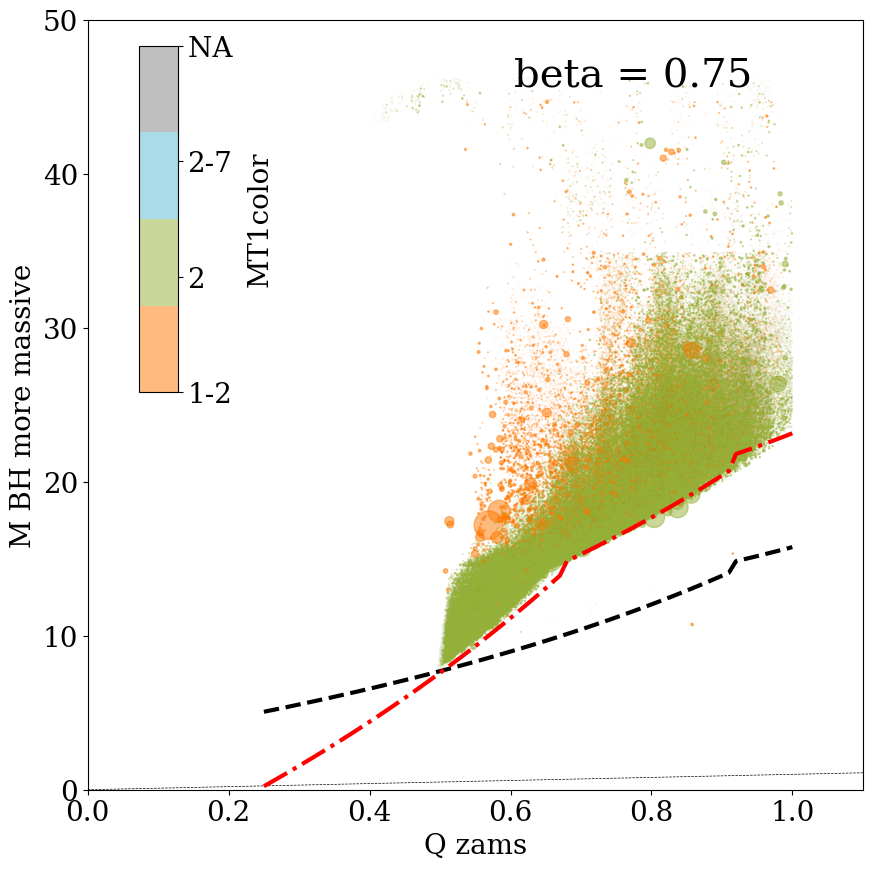

In [15]:
to_plot_table = M2_moremass_BBH #merging_BBH #
to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']

to_plot_weight = M2_moremass_Weights # Weights # 

##########################
# Scatter plot
##########################
fig, ax = plt.subplots(figsize = (10, 10))

plt.plot(np.linspace(0,50,100), np.linspace(0,50,100), '--', color='k', lw = 0.5)

kleur = 'MT1color' #'log Z' # # np.log10(M2_moremass_BBH['Metallicity@ZAMS(1)'])
im = plt.scatter(to_plot_table['qZAMS'], to_plot_table['M_moreMassive'], 
            s = 4000* to_plot_weight, c = to_plot_table[kleur], marker = 'o', 
            alpha = 0.5, vmin = 0, vmax = 3,  cmap = discrete_cmap,) #cmap = 'viridis')

# Create an inset axes for the colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 5% of parent_bbox width
                 height="45%",  # height : 50%
                 loc='lower left', bbox_to_anchor=(0.05, 0.5, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = kleur )
# Set the colorbar tick locations and labels for MT map
cbar.set_ticks(list(range(len(color_map) )))
cmap_ticks = [key.replace('             ', '') for key in color_map.keys()]
cbar.set_ticklabels(cmap_ticks)

### 
ax.plot(qzams, Min_MBH1, color = 'k', lw = 3, ls = '--', label = 'min Mbha')
ax.plot(qzams, minM_BH2, color = 'red', lw = 3, ls = '-.', label = 'min Mbhb')

# print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)


ax.text(0.55, 0.95, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=29)

ax.set_xlabel('Q zams')
ax.set_ylabel('M BH more massive')
ax.set_ylim(0,50)
ax.set_xlim(0,1.1)
plt.show()

In [16]:
merging_BBH.info()


<Table length=581432>
        name          dtype 
-------------------- -------
                SEED  uint64
             Mass(1) float64
             Mass(2) float64
     Stellar_Type(1)   int32
     Stellar_Type(2)   int32
    MT_Donor_Hist(1) bytes17
    MT_Donor_Hist(2) bytes17
             dmMT(1) float64
             dmMT(2) float64
          dmWinds(1) float64
          dmWinds(2) float64
 Metallicity@ZAMS(1) float64
   SemiMajorAxis@DCO float64
    Eccentricity@DCO float64
       Optimistic_CE   uint8
   Immediate_RLOF>CE   uint8
    CE_Event_Counter  uint32
       M_moreMassive float64
       M_lessMassive float64
              Mchirp float64
Stellar_Type@ZAMS(1)   int32
Stellar_Type@ZAMS(2)   int32
        Mass@ZAMS(1) float64
        Mass@ZAMS(2) float64
               qZAMS float64
            MT1color   int64
            MT2color   int64
